In this notebook you can find the implementation of all algorithms described in the 4th lecture of David Silver. Comment and notes are personal note and consideration in addition to the theory that can already be found in the slides. I'm not going to repeat the theory here.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Monte-Carlo-learning" data-toc-modified-id="Monte-Carlo-learning-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Monte Carlo learning</a></span><ul class="toc-item"><li><span><a href="#First-Visit-Monte-Carlo-Policy-Evaluation" data-toc-modified-id="First-Visit-Monte-Carlo-Policy-Evaluation-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>First-Visit Monte-Carlo Policy Evaluation</a></span></li><li><span><a href="#Every-Visit-Monte-Carlo-Policy-Evaluation" data-toc-modified-id="Every-Visit-Monte-Carlo-Policy-Evaluation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Every-Visit Monte-Carlo Policy Evaluation</a></span></li></ul></li><li><span><a href="#Temporal-Difference-learning" data-toc-modified-id="Temporal-Difference-learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Temporal Difference learning</a></span></li><li><span><a href="#TD(λ)" data-toc-modified-id="TD(λ)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>TD(λ)</a></span><ul class="toc-item"><li><span><a href="#Forward-view-TD(λ)" data-toc-modified-id="Forward-view-TD(λ)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Forward view TD(λ)</a></span></li><li><span><a href="#Backward-view-TD(λ)" data-toc-modified-id="Backward-view-TD(λ)-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Backward view TD(λ)</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline
from collections import defaultdict
from typing import Callable, Any
import numpy as np
import pandas as pd
import gym
import time
import cufflinks
env = gym.make('FrozenLake-v0')

In [2]:
obs = env.reset()
env.render()
done = False
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    env.render()


SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Left)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Up)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG


# Introduction
In model-free prediction we solve the task of estimating the state-value or action-value look-up table without assuming any knowledge about the transition matrix $\mathcal{S}$ and the rewards dynamics $\mathcal{R}$ of the Markov Decision Process (MDP) $<\mathcal{S}, \mathcal{A}, \mathcal{P}, \mathcal{R}, \lambda>$. This makes the algorithms applicable in the real world, were we generally don't know the dynamics of the environment.

# Monte Carlo learning

Monte Carlo (MC) learns from complete finite episodes (no bootstrapping) from the simplest possible idea: sample episodes and calculate the empirical mean of state-value or action-values. By definition $v_π(s) \doteq \mathbb{E}_π [G_t | S_t = s]$. MC replace the expectation with an average.

In [3]:
def policy_random(env: gym.Env, obs: Any):
    return env.action_space.sample()


def generate_trajectory(env: gym.Env, policy: Callable, seed: int=0):
    env.seed(seed)
    obs = env.reset()
    done = False
    states, actions, rewards = [obs], [None], [None]
    while not done:
        action = policy(env, obs)
        obs, reward, done, info = env.step(action)
        states.append(obs)
        actions.append(action)
        rewards.append(reward)
    return states, actions, rewards


def monte_carlo_leaning(env: gym.Env, policy: Callable, n_trajectories: int=1000, is_every_visit_mc: bool=False,
                        gamma: int=1, alpha: float=None):
    """Set alpha is the problem is not stationary (to slowly forget the past with EWMA), empirical mean if none."""
    N = defaultdict(int)
    V = defaultdict(float)
    V_history = dict()
    for nr_episode in range(n_trajectories):
        states, actions, rewards = generate_trajectory(env, policy, seed=nr_episode)
        nr_steps = len(states) - 1
        for t in range(nr_steps):
            S_t = states[t]
            is_first_visited = S_t not in states[:t]
            if is_every_visit_mc or is_first_visited:
                N[S_t] += 1
                coeff = 1 / N[S_t] if alpha is None else alpha
                G_t = sum(r * gamma ** i for i, r in enumerate(rewards[t+1:]))
                target = G_t
                V[S_t] = V[S_t] + coeff * (target - V[S_t])  # running mean
                
        # Update state-value look-up table.
        V_history[nr_episode] = V.copy()

    return pd.DataFrame(V_history).T

## First-Visit Monte-Carlo Policy Evaluation

State-value look-up table:


,0,1,2,3
0,0.0127,0.0102706,0.0189996,0.0121107
1,0.0142583,,0.0383171,
2,0.0326047,0.0824129,0.13229,
3,,0.162353,0.415033,


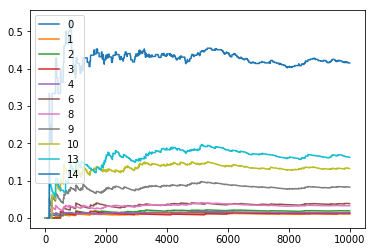

In [4]:
V_history = monte_carlo_leaning(env, policy_random, n_trajectories=10000, is_every_visit_mc=False,
                                gamma=1, alpha=None)
V_history.plot()
print('State-value look-up table:')
pd.DataFrame(V_history.iloc[-1].combine_first(pd.Series('', index=range(16))).values.reshape(4, 4)).round(4)

## Every-Visit Monte-Carlo Policy Evaluation

State-value look-up table:


,0,1,2,3
0,0.0154,0.0126665,0.0226386,0.00923361
1,0.0176218,,0.0435763,
2,0.0389709,0.101164,0.161335,
3,,0.185366,0.472393,


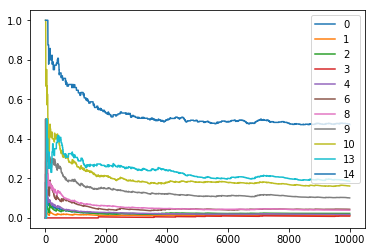

In [5]:
V_history = monte_carlo_leaning(env, policy_random, n_trajectories=10000, is_every_visit_mc=False,
                                gamma=1, alpha=None)
V_history.plot()
print('State-value look-up table:')
pd.DataFrame(V_history.iloc[-1].combine_first(pd.Series('', index=range(16))).values.reshape(4, 4)).round(4)

# Temporal Difference learning
TD learns from incomplete episodes, by bootstrapping

In [6]:
def temporal_difference_learning(env: gym.Env, policy: Callable, n_trajectories: int=1000,
                                 gamma: int=1, alpha: float=None):
    """Set alpha is the problem is not stationary (to slowly forget the past with EWMA), empirical mean if none."""
    N = defaultdict(int)
    V = defaultdict(float)
    V_history = dict()
    for nr_episode in range(n_trajectories):
        obs = env.reset()
        done = False
        while not done:
            # Interact with the environment.
            obs_old = obs
            action = policy(env, obs)
            obs, reward, done, info = env.step(action)
            
            # Update state-value function.
            N[obs_old] += 1
            target = reward + gamma * V[obs]
            error = target - V[obs_old]  # delta_t
            coeff = 1 / N[obs_old] if alpha is None else alpha
            V[obs_old] += coeff * error
        
        # Update state-value look-up table.
        V_history[nr_episode] = V.copy()
    return pd.DataFrame(V_history).T

State-value look-up table:


,0,1,2,3
0,0.00262127,0.00368819,0.0114917,0.00445542
1,0.00561273,0,0.0309065,0
2,0.0196775,0.0667255,0.119155,0
3,0,0.151735,0.416878,0


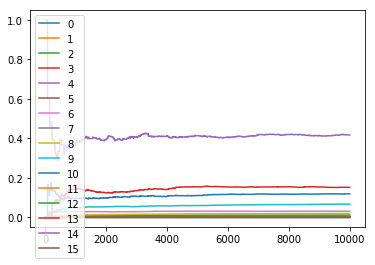

In [7]:
V_history = temporal_difference_learning(env, policy_random, n_trajectories=10000,
                                         gamma=1, alpha=None)
V_history.plot()
print('State-value look-up table:')
pd.DataFrame(V_history.iloc[-1].combine_first(pd.Series('', index=range(16))).values.reshape(4, 4)).round(4)

# TD(λ)

\begin{equation}
G_t^{(n)} = R_{t+1} + \gamma R_{t+2} + ... + \gamma^{n-1} R_{t+n} + \gamma^n V(S_{t+n})
\end{equation}

\begin{equation}
G_t^{\lambda} = \sum_{n=1}^{\inf} (1 - \lambda) \lambda^{n-1} G_t^{(n)}
\end{equation}

## Forward view TD(λ)
Like MC, can only be computed from complete episodes

\begin{equation}
V(S_t) = V(S_t) + \alpha (G_{t}^{\lambda} - V(S_t))
\end{equation}

In [8]:
def forward_td_lambda(env: gym.Env, policy: Callable, n_trajectories: int=1000, gamma: int=1,
                      alpha: float=None, lambda_: float=0.95):
    """Need to see a full episode.
    Set alpha is the problem is not stationary (to slowly forget the past with EWMA), empirical mean if none.
    If lambda=0, plain TD. If lambda=1, plain MC."""
    N = defaultdict(int)
    V = defaultdict(float)
    V_history = dict()
    for nr_episode in range(n_trajectories):
        states, actions, rewards = generate_trajectory(env, policy, seed=nr_episode)
        nr_steps = len(states) - 1  # -1 because you don't take an action in the terminal state.
        for t in range(nr_steps):
            
            # Calculate G_lambda_t, representing the target for TD(λ).
            nr_steps_left = nr_steps - t
            G_lambda_t = 0
            total_weight = sum(lambda_ ** i for i in range(nr_steps_left))  # in the limit, this is 1 / (1 - lambda_)
            for n in range(1, nr_steps_left + 1):
                # n (def): number of returns used to calculate G_t before bootstrapping with V.
                G_n_t = sum((gamma**i) * rewards[t+1+i] for i in range(n)) + (gamma**n) * V[states[t+n]]
                G_lambda_t += lambda_**(n-1) / total_weight * G_n_t
            # Note: for nr_steps_left -> +inf, the update is G_lambda_t += (1 - lambda_) * lambda_**(n-1) * G_n_t
            
            # Update state-value look-up table.
            S_t = states[t]
            target = G_lambda_t
            N[S_t] += 1
            coeff = 1 / N[S_t] if alpha is None else alpha
            V[S_t] = V[S_t] + coeff * (target - V[S_t])  # running mean
                
        # Update state-value look-up table.
        V_history[nr_episode] = V.copy()

    return pd.DataFrame(V_history).T

State-value look-up table:


,0,1,2,3
0,0.0217666,0.0170316,0.0279316,0.0148485
1,0.0237014,0,0.0422964,0
2,0.0447523,0.0936998,0.132379,0
3,0,0.179627,0.419894,0


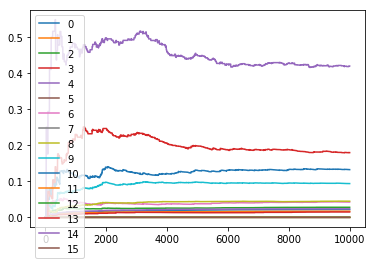

In [9]:
V_history = forward_td_lambda(env, policy_random, n_trajectories=10000,
                              gamma=1, alpha=None, lambda_=0.95)
V_history.plot()
print('State-value look-up table:')
pd.DataFrame(V_history.iloc[-1].combine_first(pd.Series('', index=range(16))).values.reshape(4, 4)).round(4)

## Backward view TD(λ)
Update online, every step, from incomplete sequences. Uses elegibility trace.

In [10]:
def backward_td_learning(env: gym.Env, policy: Callable, n_trajectories: int=1000,
                                 gamma: int=1, alpha: float=None, lambda_: float=0.95):
    """Set alpha is the problem is not stationary (to slowly forget the past with EWMA), empirical mean if none."""
    E = defaultdict(float)  # Elegibility trace
    N = defaultdict(int)
    V = defaultdict(float)
    V_history = dict()
    for nr_episode in range(n_trajectories):
        obs = env.reset()
        done = False
        while not done:
            # Interact with the environment.
            obs_old = obs
            action = policy(env, obs)
            obs, reward, done, info = env.step(action)
            
            
            # Update state-value function.
            E[obs_old] += 1
            N[obs_old] += 1
            upate_all_states = True
            if upate_all_states:
                target = reward + gamma * V[obs]
                delta = target - V[obs_old]
                for state in E:
                    coeff = 1 / N[state] if alpha is None else alpha
                    V[state] += coeff * E[state] * delta
            else:
                N[obs_old] += 1
                target = reward + gamma * V[obs]
                coeff = 1 / N[obs_old] if alpha is None else alpha
                V[obs_old] += coeff * E[obs_old] * (target - V[obs_old])
            
            for state in E:
                E[state] *= gamma * lambda_
        
        # Update state-value look-up table.
        V_history[nr_episode] = V.copy()
    return pd.DataFrame(V_history).T

State-value look-up table:


,0,1,2,3
0,0.0141513,0.0125536,0.019211,0.00877988
1,0.0166008,0,0.0395063,0
2,0.0355057,0.0849277,0.132959,0
3,0,0.156703,0.404285,0


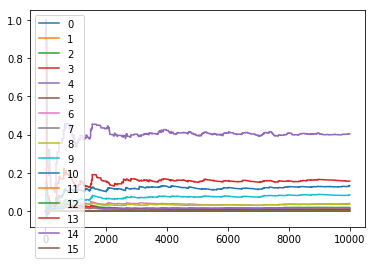

In [11]:
V_history = backward_td_learning(env, policy_random, n_trajectories=10000,
                                 gamma=1, alpha=None, lambda_=0.95)
V_history.plot()
print('State-value look-up table:')
pd.DataFrame(V_history.iloc[-1].combine_first(pd.Series('', index=range(16))).values.reshape(4, 4)).round(4)